In [95]:
# @title Importing Libraries
import pandas as pd
import numpy as np
from datetime import datetime
from scipy.stats import norm
import matplotlib.pyplot as plt

In [96]:
# @title Data Preprocessing
def clean_csv_file(input_file_path, output_file_path):
    with open(input_file_path, 'r') as file:
        lines = file.readlines()

    with open(output_file_path, 'w') as file:
        for line in lines:
            # Remove leading commas
            if line.startswith(','):
                line = line.lstrip(',')
            # Remove trailing commas
            if line.endswith(','):
                line = line.rstrip(',')
            file.write(line)

In [97]:
# @title Generating DataFrame
# Function to read and process the Nifty50 data file
def process_nifty50_data(file_path):

    df = pd.read_csv(file_path, skiprows=1)

    # Define the columns for CALLS and PUTS
    calls_columns = [
        'OI_CALL', 'CHNG IN OI_CALL', 'VOLUME_CALL', 'IV_CALL', 'LTP_CALL',
        'CHNG_CALL', 'BID QTY_CALL', 'BID_CALL', 'ASK_CALL', 'ASK QTY_CALL', 'STRIKE'
        ]
    puts_columns = [
        'BID QTY_PUT', 'BID_PUT', 'ASK_PUT', 'ASK QTY_PUT',
        'CHNG_PUT', 'LTP_PUT', 'IV_PUT', 'VOLUME_PUT', 'CHNG IN OI_PUT', 'OI_PUT', 'JK'
    ]

    # Assign the column names
    df.columns = calls_columns + puts_columns

    # Drop rows with '-' in any entry
    df.iloc[:, :-1] = df.iloc[:, :-1].replace('-', pd.NA)
    df.dropna(subset=df.columns[:-1], inplace=True)

    return df

In [98]:
# @title Black-Scholes Model
# Black-Scholes Model function
def black_scholes(S, K, T, r, sigma, option_type):
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)

    if option_type == "call":
        price = S * norm.cdf(d1, 0.0, 1.0) - K * np.exp(-r * T) * norm.cdf(d2, 0.0, 1.0)
    elif option_type == "put":
        price = K * np.exp(-r * T) * norm.cdf(-d2, 0.0, 1.0) - S * norm.cdf(-d1, 0.0, 1.0)

    return price

In [99]:
# @title Backtesting
# Backtesting function
def backtest_black_scholes(data, r, stock_price):
    results = []

    for index, row in data.iterrows():
        strike = float(row['STRIKE'].replace(',', ''))
        expiry_date = "2024-08-22"

        # Time to maturity
        T = (datetime.strptime(expiry_date, '%Y-%m-%d') - datetime.now()).days / 365.0

        # For Calls
        iv_call = float(row['IV_CALL'].replace(',', '')) / 100
        real_price_call = float(row['LTP_CALL'].replace(',', ''))
        bs_price_call = black_scholes(stock_price, strike, T, r, iv_call, option_type="call")
        error_call = abs(real_price_call - bs_price_call)

        results.append({
            'type': 'call',
            'strike': strike,
            'real_price': real_price_call,
            'bs_price': bs_price_call,
            'error': error_call
        })

        # For Puts
        iv_put = float(row['IV_PUT'].replace(',', '')) / 100
        real_price_put = float(row['LTP_PUT'].replace(',', ''))
        bs_price_put = black_scholes(stock_price, strike, T, r, iv_put, option_type="put")
        error_put = abs(real_price_put - bs_price_put)

        results.append({
            'type': 'put',
            'strike': strike,
            'real_price': real_price_put,
            'bs_price': bs_price_put,
            'error': error_put
        })

    results_df = pd.DataFrame(results)
    return results_df

In [100]:
# @title Main Function
if __name__ == "__main__":

    file_path = "/content/option-chain-ED-NIFTY-22-Aug-2024 (1).csv"  # Dataset
    r = 0.05
    stock_price = 24572.65  # Nifty50 current price

    cleaned_file_path = "cleaned_nifty50_data.csv"

    clean_csv_file(file_path, cleaned_file_path)
    nifty_data = process_nifty50_data(cleaned_file_path)

    # Backtest
    results_df = backtest_black_scholes(nifty_data, r, stock_price)
    print(results_df)

    # Evaluate performance
    mae_call = results_df[results_df['type'] == 'call']['error'].mean()
    mae_put = results_df[results_df['type'] == 'put']['error'].mean()
    print(f"Mean Absolute Error (MAE) for Calls: {mae_call}")
    print(f"Mean Absolute Error (MAE) for Puts: {mae_put}")

    type   strike  real_price     bs_price      error
0   call  24300.0      296.45   280.875207  15.574793
1    put  24300.0       28.20    16.916379  11.283621
2   call  24350.0      252.85   234.802709  18.047291
3    put  24350.0       37.40    24.423095  12.976905
4   call  24400.0      216.40   194.825190  21.574810
5    put  24400.0       48.40    34.043315  14.356685
6   call  24450.0      177.30   154.422398  22.877602
7    put  24450.0       62.00    46.727714  15.272286
8   call  24500.0      144.50   120.390530  24.109470
9    put  24500.0       79.00    63.204312  15.795688
10  call  24550.0      117.00    92.380719  24.619281
11   put  24550.0       98.70    83.125535  15.574465
12  call  24600.0       90.85    67.229232  23.620768
13   put  24600.0      124.35   109.233270  15.116730
14  call  24650.0       69.00    47.231227  21.768773
15   put  24650.0      151.00   137.557269  13.442731
16  call  24700.0       51.00    31.833438  19.166562
17   put  24700.0      180.0

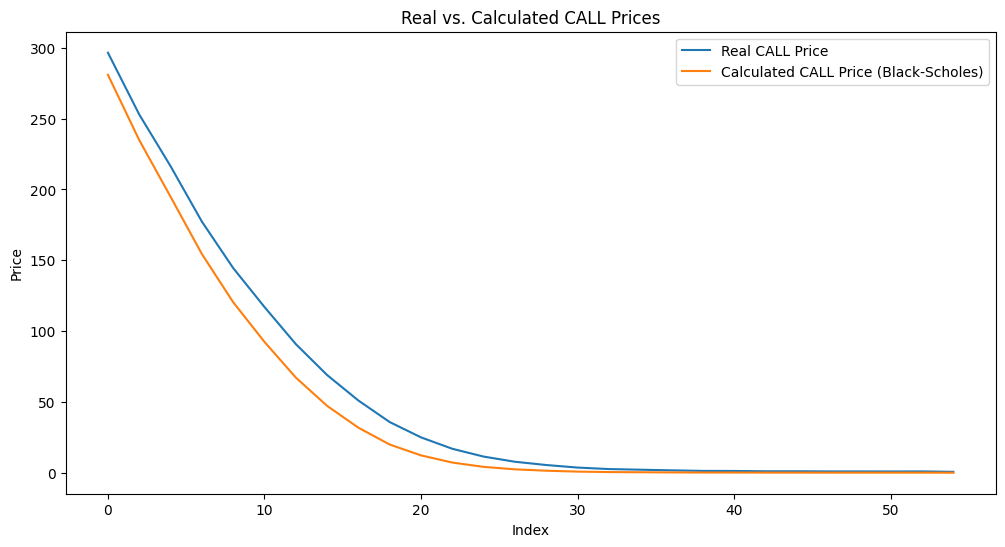

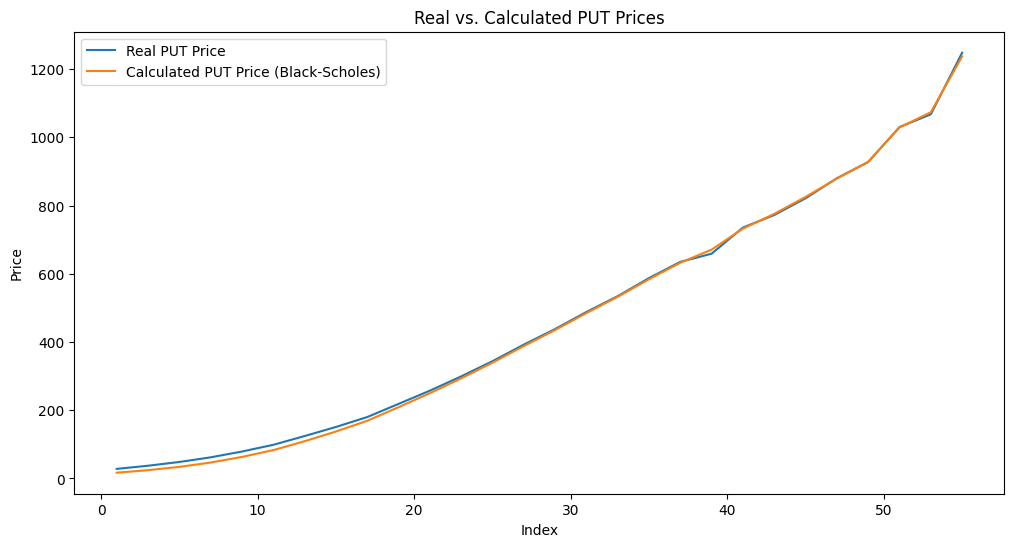

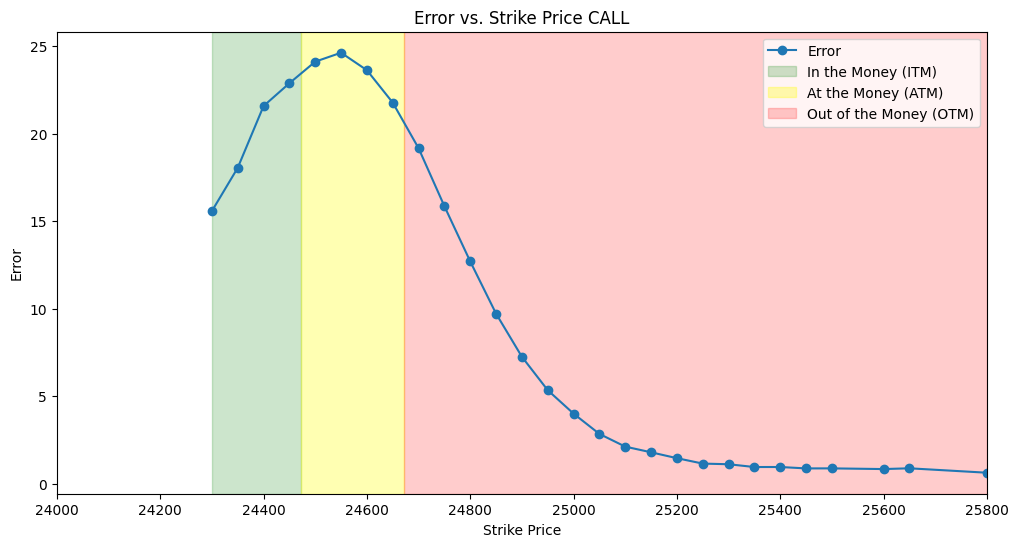

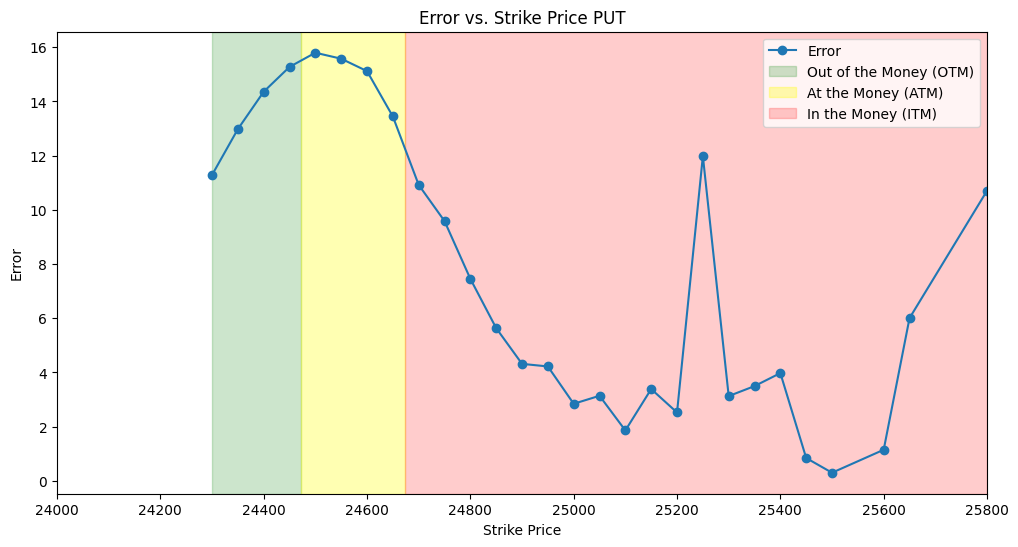

In [101]:
# @title Visualising Results
# Plot real price vs. calculated price for CALLS
plt.figure(figsize=(12, 6))
plt.plot(results_df[results_df['type'] == 'call']['real_price'], label='Real CALL Price')
plt.plot(results_df[results_df['type'] == 'call']['bs_price'], label='Calculated CALL Price (Black-Scholes)')
plt.title('Real vs. Calculated CALL Prices')
plt.xlabel('Index')
plt.ylabel('Price')
plt.legend()
plt.show()

# Plot real price vs. calculated price for PUTS
plt.figure(figsize=(12, 6))
plt.plot(results_df[results_df['type'] == 'put']['real_price'], label='Real PUT Price')
plt.plot(results_df[results_df['type'] == 'put']['bs_price'], label='Calculated PUT Price (Black-Scholes)')
plt.title('Real vs. Calculated PUT Prices')
plt.xlabel('Index')
plt.ylabel('Price')
plt.legend()
plt.show()

spot_price = stock_price

# Plot Error vs. Strike Price CALLS
plt.figure(figsize=(12, 6))
plt.plot(results_df[results_df['type'] == 'call']['strike'], results_df[results_df['type'] == 'call']['error'], label='Error', marker='o')

# Shading for ITM, ATM, OTM
plt.axvspan(24300, spot_price - 100, color='green', alpha=0.2, label='In the Money (ITM)')
plt.axvspan(spot_price - 100, spot_price + 100, color='yellow', alpha=0.3, label='At the Money (ATM)')
plt.axvspan(spot_price + 100, 25800, color='red', alpha=0.2, label='Out of the Money (OTM)')

# Set the x-axis limits from 24,300 to 25,800
plt.xlim(24000, 25800)

# Add labels and title
plt.xlabel('Strike Price')
plt.ylabel('Error')
plt.title('Error vs. Strike Price CALL')
plt.legend()
plt.show()

# Plot Error vs. Strike Price PUTS
plt.figure(figsize=(12, 6))
plt.plot(results_df[results_df['type'] == 'put']['strike'], results_df[results_df['type'] == 'put']['error'], label='Error', marker='o')

# Shading for ITM, ATM, OTM
plt.axvspan(24300, spot_price - 100, color='green', alpha=0.2, label='Out of the Money (OTM)')
plt.axvspan(spot_price - 100, spot_price + 100, color='yellow', alpha=0.3, label='At the Money (ATM)')
plt.axvspan(spot_price + 100, 25800, color='red', alpha=0.2, label='In the Money (ITM)')

# Set the x-axis limits from 24,300 to 25,800
plt.xlim(24000, 25800)

# Add labels and title
plt.xlabel('Strike Price')
plt.ylabel('Error')
plt.title('Error vs. Strike Price PUT')
plt.legend()
plt.show()